# Gap Filling & Smoothing

```
date: 2025-01-15
authors:
    - name: Brookie Guzder-Williams
affiliations:
    - University of California Berkeley, The Eric and Wendy Schmidt Center for Data Science & Environment
license: CC-BY-4.0
```

This notebook shows how DSE's [Spectral Trend Database](https://github.com/SchmidtDSE/spectral_trend_database) (STDB) processes data to create daily-smoothed values.  The steps are:

1. Perform Linear interpolation to create a daily time-series
2. Replace points where the time-series has a large drop using linear interpolation. Specifically, we create a smoothed curve by performing symmetrical mean smoothing over a 32 day window. We then remove, and then replace, points where the time-series data divide by the smoothed data is less than 0.5.
3. Apply scipy's [Savitzky Golay filter](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.savgol_filter.html) with window length 60, and polyorder 3.


---

### IMPORTS


In [1]:
from typing import Callable, Union, Optional, Literal, TypeAlias, Sequence, Any
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
from spectral_trend_database.config import config as c
from spectral_trend_database import query
from spectral_trend_database import utils
from spectral_trend_database import smoothing
from spectral_trend_database import types


---

### CONFIG

In [2]:
BQ_PREFIX = 'dse-regenag.SpectralTrendDatabase'
SAMPLE_FRAC = '0.001'
YEAR_START = 2010
YEAR_END = 2011
START_MMDD = '11-01'
END_MMDD = START_MMDD
ATTR_COLS = [
    'sample_id',
    'lon',
    'lat',
    'year']
SAMPLE_ID = 'dp176ckyu6n'


---

### HELPER METHODS


In [3]:
def print_list(lst, max_len=7, view_size=3, sep=', ', connector=' ... '):
    size = len(lst)
    if size <= max_len:
        lst_str = sep.join(lst)
    else:
        head = sep.join(lst[:view_size])        
        tail = sep.join(lst[-view_size:])
        lst_str = f'{head}{connector}{tail}  [{size}]'
    print(lst_str)

def line(marker='-', length=100):
    print(marker*length)


---

# FETCH DATA

In [4]:
meta_columns = ['sample_id', 'lon', 'lat', 'year']
qc = query.QueryConstructor('SAMPLE_POINTS', table_prefix=BQ_PREFIX)
qc.join('RAW_INDICES_V1', 'sample_id')
qc.select(*meta_columns, 'date', 'ndvi')
qc.where(sample_id=SAMPLE_ID)
qc.where('RAW_INDICES_V1', year=YEAR_START, year_op='>=')
qc.where('RAW_INDICES_V1', year=YEAR_END, year_op='<=')
qc.orderby('date', table='RAW_INDICES_V1')
df = query.run(sql=qc.sql(), print_sql=True)
print('nb_rows:', df.shape[0])

[info] spectral_trend_database.query.run: SELECT sample_id, lon, lat, year, date, ndvi FROM `dse-regenag.SpectralTrendDatabase.SAMPLE_POINTS` LEFT JOIN `dse-regenag.SpectralTrendDatabase.RAW_INDICES_V1` USING (sample_id) WHERE `dse-regenag.SpectralTrendDatabase.SAMPLE_POINTS`.sample_id = "dp176ckyu6n" AND `dse-regenag.SpectralTrendDatabase.RAW_INDICES_V1`.year >= 2010 AND `dse-regenag.SpectralTrendDatabase.RAW_INDICES_V1`.year <= 2011 ORDER BY `dse-regenag.SpectralTrendDatabase.RAW_INDICES_V1`.date ASC
nb_rows: 59


In [5]:
ds = utils.rows_to_xr(df, attr_cols=meta_columns)
ds

<xarray.Dataset>
Dimensions:  (date: 59)
Coordinates:
  * date     (date) datetime64[ns] 2010-02-25 2010-03-04 ... 2011-12-12
Data variables:
    ndvi     (date) float64 0.02882 0.147 0.1315 0.1509 ... 0.1415 0.1791 0.1498
Attributes:
    sample_id:  dp176ckyu6n
    lon:        -88.1146237542
    lat:        39.9543257816
    year:       2010

The work is being managed by `spectral_trend_database.smoothing.savitzky_golay_processor`

<xarray.Dataset>
Dimensions:  (date: 655)
Coordinates:
  * date     (date) datetime64[ns] 2010-02-25 2010-02-26 ... 2011-12-11
Data variables:
    ndvi     (date) float64 0.05741 0.06687 0.07571 ... 0.2373 0.2376 0.2375
Attributes:
    sample_id:  dp176ckyu6n
    lon:        -88.1146237542
    lat:        39.9543257816
    year:       2010

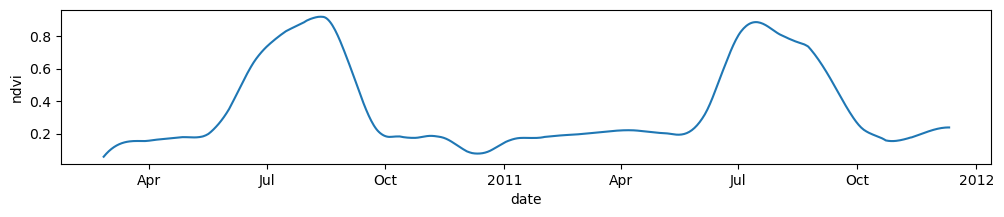

In [6]:
_ds = smoothing.savitzky_golay_processor(ds, rename=[])
display(_ds)
fig, ax = plt.subplots(figsize=(12, 2))
display(_ds.ndvi.plot())

which looks like this:

```python
def savitzky_golay_processor(
        data: types.NPXR,
        window_length: int = utils.DEFAULT_SG_WINDOW_LENGTH,
        polyorder: int = utils.DEFAULT_SG_POLYORDER,
        daily_args: Optional[types.ARGS_KWARGS] = None,
        remove_drops_args: Optional[types.ARGS_KWARGS] = None,
        interpolate_args: Optional[types.ARGS_KWARGS] = None,
        data_vars: Optional[Sequence[Union[str, Sequence]]] = None,
        exclude: Sequence[str] = [],
        rename: Union[dict[str, str], Sequence[dict[str, str]]] = {},
        **kwargs) -> types.NPXR:
    """

    Wrapper for `spectral_trend_database.utils.npxr.sequence` to run a series of smoothing steps

    Steps:
        1. daily_dataset
        2. interpolate_na
        3. remove_drops
        4. interpolate_na
        5. npxr_savitzky_golay

    Args:

        data (types.NPXR): source data
        window_length (int = DEFAULT_SG_WINDOW_LENGTH): window_length for sig.savgol_filter
        polyorder (int = DEFAULT_SG_POLYORDER): polyorder for sig.savgol_filter
        daily_args (Optional[types.ARGS_KWARGS] = None):

        remove_drops_args (Optional[types.ARGS_KWARGS] = None):

        interpolate_args (Optional[types.ARGS_KWARGS] = None):

        data_vars (Optional[Sequence[Union[str, Sequence]]] = None):

        exclude (Sequence[str] = []):

        rename (Union[dict[str, str], Sequence[dict[str, str]]] = {}):
        **kwargs: additional kwargs for sig.savgol_filter

    Returns:

        (types.NPXR) data with smoothed data values
    """
    kwargs['window_length'] = window_length
    kwargs['polyorder'] = polyorder
    func_list = [
        daily_dataset,
        interpolate_na,
        remove_drops,
        interpolate_na,
        npxr_savitzky_golay
    ]
    args_list = [
        daily_args,
        interpolate_args,
        remove_drops_args,
        interpolate_args,
        kwargs
    ]
    return sequencer(
        data,
        data_vars=data_vars,
        exclude=exclude,
        rename=rename,
        func_list=func_list,
        args_list=args_list)
```

For this examplew we'll break the `savitzky_golay_processor` up into the three steps defined above, namely:

1. `linear_interp`: Perform Linear interpolation to create a daily time-series
2. `replace_drops`: Replace points where the time-series has a large drop using linear interpolation. Specifically, we create a smoothed curve by performing symmetrical mean smoothing over a 32 day window. We then remove, and then replace, points where the time-series data divide by the smoothed data is less than 0.5.
3. `sg_filter`: Apply scipy's [Savitzky Golay filter](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.savgol_filter.html) with window length 60, and polyorder 3.

In [7]:
def linear_interp(
        data: types.NPXR,
        daily_args: Optional[types.ARGS_KWARGS] = None,
        interpolate_args: Optional[types.ARGS_KWARGS] = None,
        rename: Union[dict[str, str], Sequence[dict[str, str]]] = {}) -> types.NPXR:
    func_list = [
        smoothing.daily_dataset,
        smoothing.interpolate_na,
    ]
    args_list = [
        daily_args,
        interpolate_args
    ]
    return smoothing.sequencer(
        data,
        rename=rename,
        func_list=func_list,
        args_list=args_list)

def replace_drops(
        data: types.NPXR,
        remove_drops_args: Optional[types.ARGS_KWARGS] = None,
        interpolate_args: Optional[types.ARGS_KWARGS] = None,
        rename: Union[dict[str, str], Sequence[dict[str, str]]] = {},
        **kwargs) -> types.NPXR:
    func_list = [
        smoothing.remove_drops,
        smoothing.interpolate_na,
    ]
    args_list = [
        remove_drops_args,
        interpolate_args,
    ]
    return smoothing.sequencer(
        data,
        rename=rename,
        func_list=func_list,
        args_list=args_list)

def sg_filter(
        data: types.NPXR,
        window_length: int = smoothing.DEFAULT_SG_WINDOW_LENGTH,
        polyorder: int = smoothing.DEFAULT_SG_POLYORDER,
        rename: Union[dict[str, str], Sequence[dict[str, str]]] = {},
        **kwargs) -> types.NPXR:
    """ 
    NOTE: this is just a complicated wrapping of `smoothing.npxr_savitzky_golay`. Keeping it
    in this format for consistency with `smoothing.savitzky_golay_processor` and the above
    methods (linear_interp, replace_drops).
    """
    kwargs['window_length'] = window_length
    kwargs['polyorder'] = polyorder
    func_list = [
        smoothing.npxr_savitzky_golay
    ]
    args_list = [
        kwargs
    ]
    return smoothing.sequencer(
        data,
        rename=rename,
        func_list=func_list,
        args_list=args_list)

In [8]:
ds_1 = linear_interp(ds, rename=dict(ndvi='ndvi_linear_interp'))
ds_2 = replace_drops(ds_1, rename=dict(ndvi_linear_interp='ndvi_remove_drops'))
ds_3 = sg_filter(ds_2, rename=dict(ndvi_remove_drops='ndvi_sg'))

In [9]:
#| label: nb.smoothed_dataset

ds_smoothed = utils.npxr_stack([ds_1, ds_2, ds_3], dim='date')
display(ds_smoothed)

<xarray.Dataset>
Dimensions:             (date: 655)
Coordinates:
  * date                (date) datetime64[ns] 2010-02-25 ... 2011-12-11
Data variables:
    ndvi_linear_interp  (date) float64 0.02882 0.0457 0.06259 ... 0.2431 0.2453
    ndvi_remove_drops   (date) float64 0.02882 0.0457 0.06259 ... 0.2431 0.2453
    ndvi_sg             (date) float64 0.05741 0.06687 0.07571 ... 0.2376 0.2375
Attributes:
    sample_id:  dp176ckyu6n
    lon:        -88.1146237542
    lat:        39.9543257816
    year:       2010

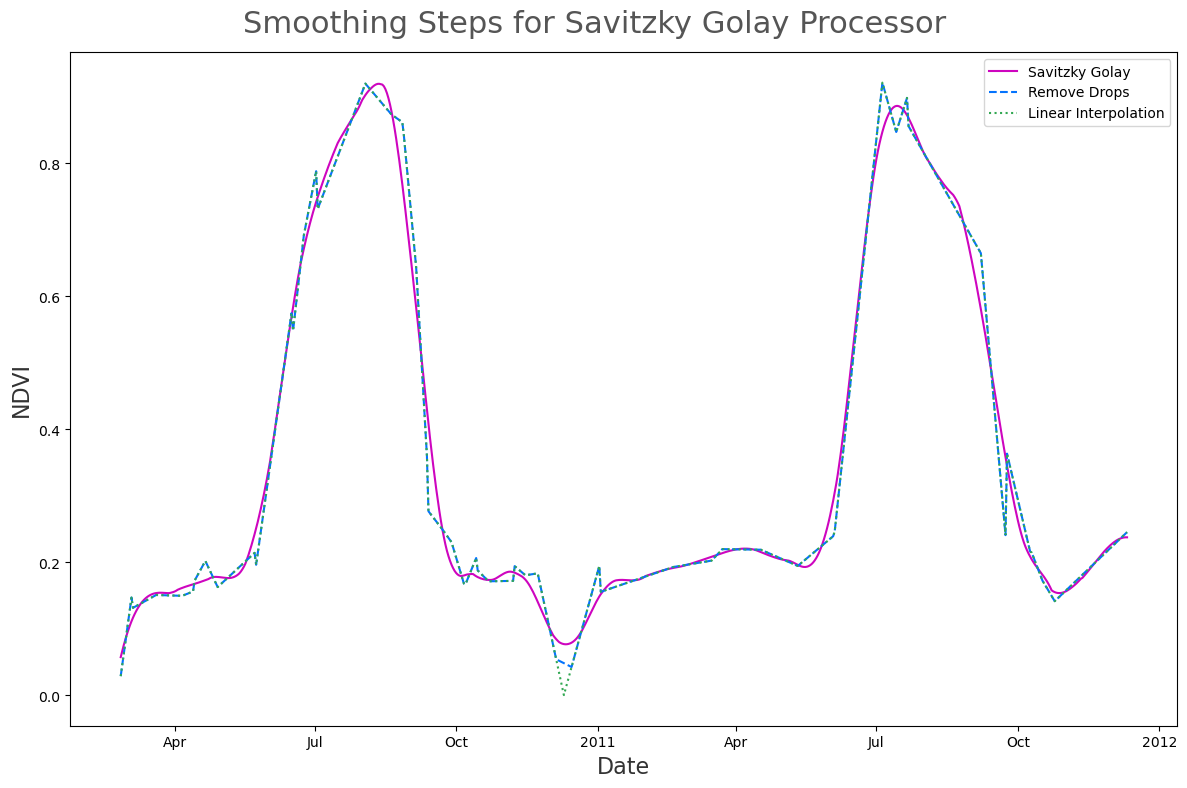

In [10]:
#| label: nb.smoothing
#| placeholder: ./images/TBD.png

SUPTITLE_FONT_SIZE = 22
SUPTITLE_CLR = '#555'
LABEL_FONT_SIZE = 16
LABEL_CLR = '#333'

fig, ax = plt.subplots(figsize=(12, 8))
ds_smoothed.ndvi_sg.plot(color='#ce05bf', label='Savitzky Golay')
ds_smoothed.ndvi_remove_drops.plot(color='#0473fd', linestyle='dashed', label='Remove Drops')
ds_smoothed.ndvi_linear_interp.plot(color='#32a852', linestyle='dotted', label='Linear Interpolation')
plt.suptitle(
    'Smoothing Steps for Savitzky Golay Processor',
    fontsize=SUPTITLE_FONT_SIZE,
    color=SUPTITLE_CLR)
ax.set_ylabel('NDVI', fontsize=LABEL_FONT_SIZE, color=LABEL_CLR)
ax.set_xlabel('Date', fontsize=LABEL_FONT_SIZE, color=LABEL_CLR)
plt.legend(loc=1)
plt.tight_layout()